### Mount Drive and hold imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#imports
!pip install geocoder
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from string import ascii_letters


import geocoder
import seaborn as sns

     |████████████████████████████████| 98 kB 5.2 MB/s 


### Load in initial housing data

In [ ]:
#import data
housing_df = pd.read_csv("housing.csv")
# housing_df = pd.read_csv("/content/drive/MyDrive/housing.csv")
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [ ]:
#clean data (dropping nulls, na)
# Drop duplicate rows
housing_df = housing_df.drop_duplicates()

In [ ]:
# Drow rows that have any nulls (NaN) in them
housing_df = housing_df.dropna(axis = 0)

### One time run step to extract zip code, city and county from the housing data

In [ ]:
# Take in a row from the data frame and extract the zip code (postal), city and county associated with the latitude and longitude
def extractGeoLocationData(row):
    try:
        g = geocoder.mapquest([row['latitude'], row['longitude']], method='reverse', key='p39RsNn4xWJHVlfQ5l0IDHw4pDCA8bPE').json
        # Store the variables in a python object.
        geoData = {}
        geoData['postal'] = g['postal']
        geoData['city'] = g['city']
        geoData['county'] = g['county']
        return geoData
    except:
        geoData = {}
        geoData['postal'] = None
        geoData['city'] = None
        geoData['county'] = None
        return geoData

In [ ]:
# Due to the use of the mapquest API, a maximum of 15000 API calls can be made, all members had to create an account and extract the geolocation
# data for chunks of the data until all data points have been run.

# Slice the housing_df dataframe and run the geolocation extractor.
def geoLocationExtractor(start, end):
  sliced_df = housing_df.iloc[start:end]
  return sliced_df.apply(lambda row: extractGeoLocationData(row), axis=1)

slicedGeoLocationData = geoLocationExtractor(10000, 15000)
slicedGeoLocationData

NameError: ignored

In [ ]:
# Reset the indices in order to iterate through the list.
slicedGeoLocationData = slicedGeoLocationData.reset_index(drop=True)
slicedGeoLocationData

NameError: ignored

In [ ]:
# Generate a pandas dataframe and run through the list to store the postal code, city and county.
sliced_geo_df = pd.DataFrame()
postalList = []
cityList = []
countyList = []
def getArray(val):
  postalList.append(val['postal'])
  cityList.append(val['city'])
  countyList.append(val['county'])

for i in range(len(slicedGeoLocationData)):
  try:
    getArray(slicedGeoLocationData[i])
  except Exception as err:
    print(err)
    postalList.append(None)
    cityList.append(None)
    countyList.append(None)

sliced_geo_df['postal'] = postalList
sliced_geo_df['city'] = cityList
sliced_geo_df['county'] = countyList

In [ ]:
sliced_geo_df

In [ ]:
# Store the partial data in a temporary csv
sliced_geo_df.to_csv('/content/drive/MyDrive/partialData3.csv', index=False)

In [ ]:
# Once all of the data has been run through, read all the csv files partially generated.
data1_df = pd.read_csv("/content/drive/MyDrive/partialData1.csv")
data2_df = pd.read_csv("/content/drive/MyDrive/partialData2.csv")
data3_df = pd.read_csv("/content/drive/MyDrive/partialData3.csv")

In [ ]:
# Build out a dataframe of the partial data and append in the order they were read.
data_df = data1_df.append(data2_df, ignore_index=True)
data_df = data_df.append(data3_df, ignore_index=True)
data_df = data_df.append(data4_df, ignore_index=True)

In [ ]:
# Take in the housing dataframe and update all rows with the postal, city and county data.
housing_zip_df = housing_df.reset_index(drop=True)
housing_zip_df[['postal', 'city', 'county']] = data_df[['postal', 'city', 'county']]

# Take in the postal code and only hold the first 5 digits (zip-code).
housing_zip_df['postal'] = housing_zip_df['postal'].apply(lambda x: int(x[0:5]) if type(x) == str else x)

In [ ]:
# Write the updated data with zip information into another csv in order to not need to run the above procedure again.
housing_zip_df.to_csv('/content/drive/MyDrive/housing_with_zip.csv', index=False)

### Load in the updated Zip Code CSV

In [ ]:
# housing_with_zip_df = pd.read_csv("/content/drive/MyDrive/housing_with_zip.csv")
housing_df = pd.read_csv("housing_with_zip.csv")

# Since some rows were unable to find appropriate zip codes from the data, drop any nulls found in the data.
housing_df = housing_df.dropna(axis = 0)
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,postal,city,county
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,94720.0,Berkeley,Alameda
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,94611.0,Oakland,Alameda
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,94618.0,Oakland,Alameda
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,94618.0,Oakland,Alameda
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,94618.0,Oakland,Alameda


### EDA Visuals (e.g. lat/long plots, correlation plots, any other interesting plots)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4cdfe1e850>,
      dtype=object)

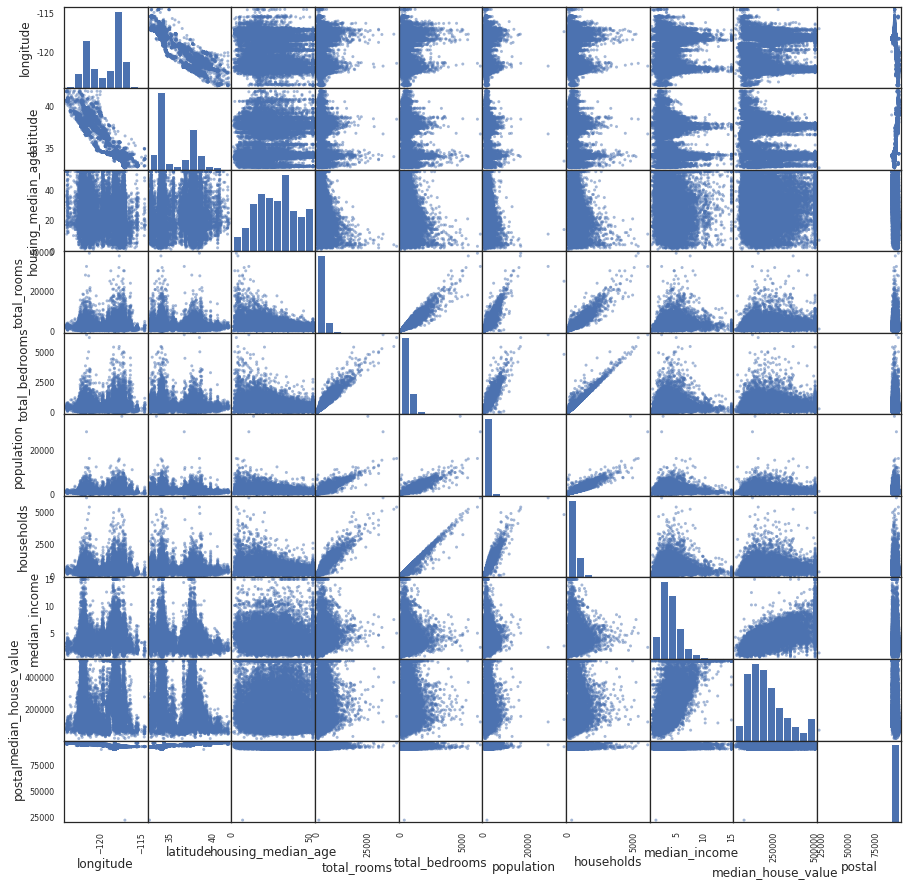

In [ ]:
pd.plotting.scatter_matrix(housing_df,figsize=(15,15))

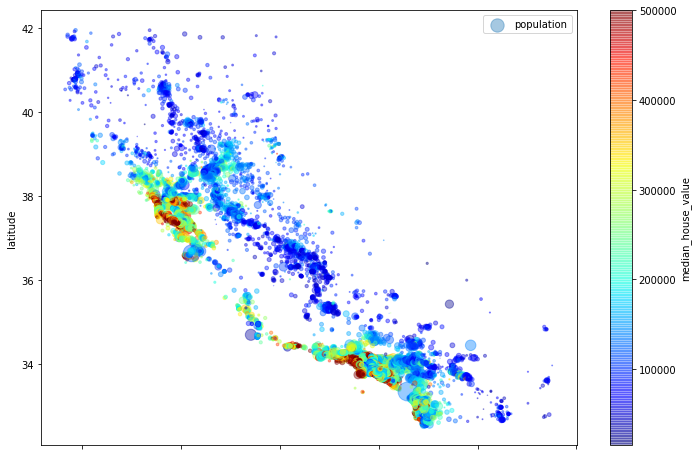

In [ ]:
#plot median house price vs. location
#TO-DO: make our own

housing_df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing_df['population']/100, label='population',
figsize=(12, 8), c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()
plt.show()

In [ ]:
# Correlation Matrix
correlation_matrix = housing_df.corr()
correlation_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,postal
longitude,1.000000,-0.927109,-0.113396,0.045801,0.069900,0.101097,0.056829,-0.017969,-0.050981,-0.758784
latitude,-0.927109,1.000000,0.016619,-0.035339,-0.065940,-0.108097,-0.069865,-0.074220,-0.135554,0.833974
housing_median_age,-0.113396,0.016619,1.000000,-0.362159,-0.321973,-0.298414,-0.305404,-0.120184,0.107296,-0.149919
total_rooms,0.045801,-0.035339,-0.362159,1.000000,0.930224,0.858161,0.919439,0.197714,0.132258,0.026469
total_bedrooms,0.069900,-0.065940,-0.321973,0.930224,1.000000,0.879226,0.980671,-0.008753,0.047752,-0.032556
population,0.101097,-0.108097,-0.298414,0.858161,0.879226,1.000000,0.907303,0.003319,-0.026023,-0.070549
households,0.056829,-0.069865,-0.305404,0.919439,0.980671,0.907303,1.000000,0.011373,0.063123,-0.038660
median_income,-0.017969,-0.074220,-0.120184,0.197714,-0.008753,0.003319,0.011373,1.000000,0.688389,-0.029536
median_house_value,-0.050981,-0.135554,0.107296,0.132258,0.047752,-0.026023,0.063123,0.688389,1.000000,-0.169004
postal,-0.758784,0.833974,-0.149919,0.026469,-0.032556,-0.070549,-0.038660,-0.029536,-0.169004,1.000000


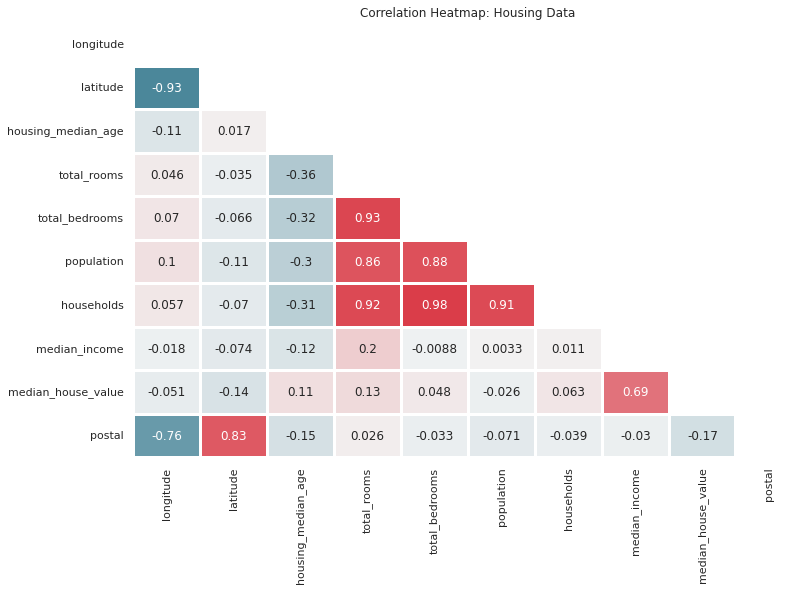

In [ ]:
sns.set(style = "white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Generate a mask for the upper triangle
mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True, center='light')

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, vmax=1,vmin=-1,center=0, square=False, annot=True, cmap=cmap, mask=mask, lw=2, cbar=False)

plt.title("Correlation Heatmap: Housing Data")
plt.show()

In [ ]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,postal,city,county
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,94720.0,Berkeley,Alameda
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,94611.0,Oakland,Alameda
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,94618.0,Oakland,Alameda
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,94618.0,Oakland,Alameda
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,94618.0,Oakland,Alameda


1. One-hot encode the following categories - zipcodes, city, county, ocean_proximity
2. Set-up training and testing x/y data (y=median_house_value)
3. Set up models (random forest, logistic regression, other?)

In [ ]:
#one-hot encoding

# postal_oh = pd.get_dummies(housing_df['postal'], prefix='postal')
county_oh = pd.get_dummies(housing_df['county'], prefix='county')
# city_oh = pd.get_dummies(housing_df['city'], prefix='city')
ocean_oh = pd.get_dummies(housing_df['ocean_proximity'], prefix='ocean_proximity')
county_oh.head()

,county_Alameda,county_Alpine,county_Amador,county_Butte,county_Calaveras,county_Colusa,county_Contra Costa,county_Del Norte,county_Douglas,county_El Dorado,county_Fresno,county_Glenn,county_Humboldt,county_Imperial,county_Inyo,county_Kern,county_Kings,county_Lake,county_Lassen,county_Los Angeles,county_Madera,county_Marin,county_Mariposa,county_Mendocino,county_Merced,county_Modoc,county_Mono,county_Monterey,county_Napa,county_Nevada,county_Orange,county_Placer,county_Plumas,county_Riverside,county_Sacramento,county_San Benito,county_San Bernardino,county_San Diego,county_San Francisco,county_San Joaquin,county_San Luis Obispo,county_San Mateo,county_Santa Barbara,county_Santa Clara,county_Santa Cruz,county_Shasta,county_Sierra,county_Siskiyou,county_Solano,county_Sonoma,county_Stanislaus,county_Sutter,county_Tehama,county_Tijuana,county_Trinity,county_Tulare,county_Tuolumne,county_Ventura,county_Yolo,county_Yuba
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
housing_df_logistic = housing_df
housing_df_logistic = housing_df_logistic.drop(columns=['city','postal','ocean_proximity'])
housing_df_logistic.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,county
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,Alameda
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,Alameda
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,Alameda
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,Alameda
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,Alameda


In [ ]:
#combine dataframe with OH data
# housing_df = pd.concat([housing_df,postal_oh,county_oh,city_oh,ocean_oh],axis=1)
# housing_df = housing_df.drop(columns=['postal', 'county','city','ocean_proximity'])

housing_df = pd.concat([housing_df,county_oh,ocean_oh],axis=1)
housing_df = housing_df.drop(columns=['county','ocean_proximity'])

housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,postal,city,county_Alameda,county_Alpine,county_Amador,county_Butte,county_Calaveras,county_Colusa,county_Contra Costa,county_Del Norte,county_Douglas,county_El Dorado,county_Fresno,county_Glenn,county_Humboldt,county_Imperial,county_Inyo,county_Kern,county_Kings,county_Lake,county_Lassen,county_Los Angeles,county_Madera,county_Marin,county_Mariposa,county_Mendocino,county_Merced,county_Modoc,county_Mono,county_Monterey,county_Napa,county_Nevada,county_Orange,county_Placer,county_Plumas,county_Riverside,county_Sacramento,county_San Benito,county_San Bernardino,county_San Diego,county_San Francisco,county_San Joaquin,county_San Luis Obispo,county_San Mateo,county_Santa Barbara,county_Santa Clara,county_Santa Cruz,county_Shasta,county_Sierra,county_Siskiyou,county_Solano,county_Sonoma,county_Stanislaus,county_Sutter,county_Tehama,county_Tijuana,county_Trinity,county_Tulare,county_Tuolumne,county_Ventura,county_Yolo,county_Yuba,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,94720.0,Berkeley,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,94611.0,Oakland,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,94618.0,Oakland,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,94618.0,Oakland,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,94618.0,Oakland,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
housing_df = housing_df.drop(columns=['city','postal'])
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,county_Alameda,county_Alpine,county_Amador,county_Butte,county_Calaveras,county_Colusa,county_Contra Costa,county_Del Norte,county_Douglas,county_El Dorado,county_Fresno,county_Glenn,county_Humboldt,county_Imperial,county_Inyo,county_Kern,county_Kings,county_Lake,county_Lassen,county_Los Angeles,county_Madera,county_Marin,county_Mariposa,county_Mendocino,county_Merced,county_Modoc,county_Mono,county_Monterey,county_Napa,county_Nevada,county_Orange,county_Placer,county_Plumas,county_Riverside,county_Sacramento,county_San Benito,county_San Bernardino,county_San Diego,county_San Francisco,county_San Joaquin,county_San Luis Obispo,county_San Mateo,county_Santa Barbara,county_Santa Clara,county_Santa Cruz,county_Shasta,county_Sierra,county_Siskiyou,county_Solano,county_Sonoma,county_Stanislaus,county_Sutter,county_Tehama,county_Tijuana,county_Trinity,county_Tulare,county_Tuolumne,county_Ventura,county_Yolo,county_Yuba,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
#maybe drop some catoeiges - curse of dimensionality!!!

In [ ]:
#generate labels and features
label =housing_df['median_house_value']
features = housing_df.drop(columns=['median_house_value'])

In [ ]:
features.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,county_Alameda,county_Alpine,county_Amador,county_Butte,county_Calaveras,county_Colusa,county_Contra Costa,county_Del Norte,county_Douglas,county_El Dorado,county_Fresno,county_Glenn,county_Humboldt,county_Imperial,county_Inyo,county_Kern,county_Kings,county_Lake,county_Lassen,county_Los Angeles,county_Madera,county_Marin,county_Mariposa,county_Mendocino,county_Merced,county_Modoc,county_Mono,county_Monterey,county_Napa,county_Nevada,county_Orange,county_Placer,county_Plumas,county_Riverside,county_Sacramento,county_San Benito,county_San Bernardino,county_San Diego,county_San Francisco,county_San Joaquin,county_San Luis Obispo,county_San Mateo,county_Santa Barbara,county_Santa Clara,county_Santa Cruz,county_Shasta,county_Sierra,county_Siskiyou,county_Solano,county_Sonoma,county_Stanislaus,county_Sutter,county_Tehama,county_Tijuana,county_Trinity,county_Tulare,county_Tuolumne,county_Ventura,county_Yolo,county_Yuba,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
#train test split data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.20)

In [ ]:
##try linear regression model to start out with

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from datetime import datetime
# Your code goes here
regr = LinearRegression()

start = datetime.now()

regr.fit(x_train,y_train)

y_pred = regr.predict(x_test)

stop = datetime.now()

delta = stop-start
seconds_lr = delta.seconds + delta.microseconds/1E6

print("TRAIN:", regr.score(x_train,y_train))
print("TEST:", regr.score(x_test,y_test))

mse_test = mean_squared_error(y_pred,y_test)
print("Test MSE: ",mse_test)
print("Test RMSE: ",mse_test**0.5)
print("Time (sec): ",seconds_lr)



TRAIN: 0.6911729684388902
TEST: 0.7038430450930451
Test MSE:  3865647972.888673
Test RMSE:  62174.33532325595
Time (sec):  0.059724


([<matplotlib.axis.XTick at 0x7f4cee6ebad0>,
 <a list of 10 Text major ticklabel objects>)

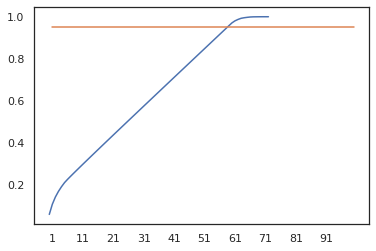

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Your code goes here

# Fit the features to the standard scaler
features = StandardScaler().fit_transform(features)

# Run PCA
pca = PCA()
X2 = pca.fit_transform(features)
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(pc_vs_variance)
x_coordinates = [1, 100]
y_coordinates = [0.95, 0.95]
plt.plot(x_coordinates, y_coordinates)
plt.xticks(np.arange(1, 100, 10))

In [ ]:
# From the graph above, we can see that ~95% of the variance occurs at the ~55 components mark
pca = PCA(n_components=55)

# Update the PCA model and transform the x training and test features.
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

In [ ]:
#use grid search cv to find best parameters
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV




##### to-do grid search cv #####
#run param grid on n_estimators, and max_depth



In [ ]:
rfr1 =RandomForestRegressor(n_estimators= 5)

start = datetime.now()

rfr1.fit(x_train_pca,y_train)
y_pred = rfr1.predict(x_test_pca)

stop = datetime.now()
delta = stop-start
seconds_rf = delta.seconds + delta.microseconds/1E6

mse_test = mean_squared_error(y_pred,y_test)

print("TEST MSE: ",mse_test)
print("SQUARE ROOT TEST MSE: ", mse_test**0.5)
print("Time (sec): ",seconds_rf)
print("TRAIN SCORE: ", rfr1.score(x_train_pca,y_train))
print("TEST SCORE: ", rfr1.score(x_test_pca,y_test))

TEST MSE:  2850365380.666484
SQUARE ROOT TEST MSE:  53388.813253962515
Time (sec):  3.771798
TRAIN SCORE:  0.950465118015136
TEST SCORE:  0.781626382580414


In [ ]:
#discuss differences in train and test scores between RF and LR
#explain how LR might not be best suited given the categorical data we're dealing with

In [ ]:
##### LOGISTIC REGRESSION - PREDICT COUNTRY GIVEN HOUSING DATA ######
housing_df_logistic.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,county
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,Alameda
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,Alameda
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,Alameda
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,Alameda
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,Alameda


In [ ]:
#generate labels and features
label_logistic = housing_df_logistic['county']
features_logistic = housing_df_logistic.drop(columns=['county'])

In [ ]:
#scale logistic regression data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
 
features_logistic_scaled = scaler.fit_transform(features_logistic.to_numpy())

features_logistic_scaled = pd.DataFrame(features_logistic_scaled, columns=features_logistic.columns)

features_logistic_scaled.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.335899,1.063371,0.975294,-0.803159,-0.968921,-0.974932,-0.977568,2.348916,2.147131
1,-1.330893,1.053968,-0.610710,2.037613,1.344648,0.853079,1.661951,2.336359,1.325856
2,-1.340905,1.049267,1.847597,-0.535023,-0.824471,-0.821938,-0.844549,1.785569,1.269999
3,-1.345911,1.049267,1.847597,-0.623184,-0.717910,-0.767423,-0.735003,0.933901,1.175740
4,-1.345911,1.049267,1.847597,-0.461937,-0.611348,-0.761268,-0.630675,-0.014103,1.183595


In [ ]:
features_logistic_scaled.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.335899,1.063371,0.975294,-0.803159,-0.968921,-0.974932,-0.977568,2.348916,2.147131
1,-1.330893,1.053968,-0.610710,2.037613,1.344648,0.853079,1.661951,2.336359,1.325856
2,-1.340905,1.049267,1.847597,-0.535023,-0.824471,-0.821938,-0.844549,1.785569,1.269999
3,-1.345911,1.049267,1.847597,-0.623184,-0.717910,-0.767423,-0.735003,0.933901,1.175740
4,-1.345911,1.049267,1.847597,-0.461937,-0.611348,-0.761268,-0.630675,-0.014103,1.183595


In [ ]:
x_train_lg, x_test_lg, y_train_lg, y_test_lg = train_test_split(features_logistic_scaled, label_logistic, test_size=0.20)

In [ ]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(max_iter=1000)

start = datetime.now()

# fit the model with data
logreg.fit(x_train_lg,y_train_lg)

#
y_pred_lg = logreg.predict(x_test_lg)
y_pred_train_lg = logreg.predict(x_train_lg)

stop = datetime.now()

delta = stop-start
seconds = delta.seconds + delta.microseconds/1E6



In [ ]:
from sklearn import metrics

print("Train Accuracy:",metrics.accuracy_score(y_train_lg, y_pred_train_lg)) #true y labes against predictions given input training x
print("Test Accuracy:",metrics.accuracy_score(y_test_lg, y_pred_lg)) #.. "" "" given x test
print("Total runtime (seconds): ", seconds)
# print("Precision:",metrics.precision_score(y_test, y_pred))
# print("Recall:",metrics.recall_score(y_test, y_pred))

Train Accuracy: 0.7165875593305021
Test Accuracy: 0.7195304695304695
Total runtime (seconds):  30.653942


In [ ]:
#challenges with Log Reg - convergence issues, solved by rescaling data and increasing the max number of iterations...